Briefly about content:
* Train model with DQN algorithm for Mountain car problem
* Use Experience Replay, Reward Shaping techniques and Auxiliary loss
* Test different setups (Model's arhitecture, Reward function, Loss function) to find best one

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import copy
import random
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from collections import Iterable
import gym

### Problem

Let's get some information about environment

In [2]:
env = gym.make("MountainCar-v0")

In [3]:
print(env.action_space)
print(env.observation_space)
print(env.observation_space.high)
print(env.observation_space.low)

Discrete(3)
Box(2,)
[0.6  0.07]
[-1.2  -0.07]


In [4]:
total_rewards = []
episode_max = 1000

for episode in range(episode_max):
    state = env.reset()
    episode_reward = 0
    
    done = False
    while not done:
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        episode_reward += reward
        
        if done:
            total_rewards.append(episode_reward)
            break
env.close()

In [5]:
np.unique(total_rewards, return_counts=True)

(array([-200.]), array([1000], dtype=int64))

In [6]:
total_rewards = np.array(total_rewards)
print(f"Task was solved {len(total_rewards[total_rewards > -200])} times out of {episode_max} with random action algorithm.")

Task was solved 0 times out of 1000 with random action algorithm.


It's clear that provided task is very unlikely to be solved with simple policy of taking random actions. Let's try to learn optimal policy with deep Q learning algorithm. More precisely, we will learn Q values and than take based on them choose next action.

### Model

Let's first define DL model

In [7]:
observation_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

In [8]:
def create_model(hidden_dim=30):
    return nn.Sequential(
        nn.Linear(observation_space_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, action_space_dim)
    )

In [9]:
def init_weights_default(layer):
    pass

In [10]:
def init_weights_xavier(layer):
    if type(layer) == nn.Linear:
        nn.init.xavier_normal_(layer.weight)

In [11]:
model = create_model()
print(model)

Sequential(
  (0): Linear(in_features=2, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=30, bias=True)
  (3): ReLU()
  (4): Linear(in_features=30, out_features=3, bias=True)
)


In deep learning, the target labels are not changing over training. That makes training stable. Since in Q learning estimation of Q-values is based on another Q-values we are dealing with continiously changing target. To make RL model more stable we will use two models. One will be fixed till another one is training. Once in a while we will update first model too. Information is took from [Analytics Vidhya](https://www.analyticsvidhya.com/blog/2019/04/introduction-deep-q-learning-python/).

#### Auxiliary Tasks

Inspired by paper [REINFORCEMENT LEARNING WITH UNSUPERVISED AUXILIARY TASKS](https://arxiv.org/pdf/1611.05397.pdf), emerged idea of adding auxiliary loss to original task to improve model's perfomance.

In [12]:
class ModelAuxiliary(nn.Module):
    def __init__(self, hidden_dim=30):
        super().__init__()
        self.fc1 = nn.Linear(observation_space_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_space_dim)
        self.fc4 = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        """Predicts action"""
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
    def forward_reward(self, x):
        """Predicts reward of action"""
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc4(x)

In [13]:
model = ModelAuxiliary()
print(model)

ModelAuxiliary(
  (fc1): Linear(in_features=2, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=3, bias=True)
  (fc4): Linear(in_features=30, out_features=1, bias=True)
)


In [14]:
def create_model(hidden_dim=30, auxiliary_task=False):
    if auxiliary_task:
        return ModelAuxiliary(hidden_dim)
    else:
        return nn.Sequential(
            nn.Linear(observation_space_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_space_dim)
        )

### Experience Replay

Also we will use Experience replay technique. Good motivation and explonation of it is provided in [Dealing with Sparse Rewards in Reinforcement Learning](https://arxiv.org/abs/1910.09281):

If using a gradient based iterative optimisation process as done via back-propagation in
neural networks, it is important that the data is independent and identically distributed (i.i.d.).
This is done as to avoid sampling bias from correlated inputs, which can cause the gradient to get
stuck in a non-optimal local maxima (as we are performing gradient ascent to maximise the expected
future reward). Experience replay is a method to help decorrelate the sequential experiences gained
from dynamic programming and model free reinforcement learning methods. This is done by storing
experiences, a tuple of (st, at, rt, st+1) into a list of experiences known as the replay memory. Batch
samples can be drawn randomly from the replay memory which provide ∼ i.i.d. for a large replay
length.

In [15]:
class Experience:
    """Class for implementing Experience Replay technique"""
    def __init__(self, capacity, weighted=False):
        self.capacity = capacity
        self.experience = []
        self.weighted = weighted

    def add(self, el):
        self.experience.append(el)
        self.experience = self.experience[-self.capacity:]

    def sample(self, batch_size):
        if self.weighted:
            raise NotImplementedError
        else:
            return random.sample(self.experience, batch_size)

There is one possible improvement in base Experience Replay method regarding the way of sampling. We can use weighted sampling to put more attention to states with greater reward.

### Fitting network

To fit network we have to calculate predicted by model Q-values and target Q-values created by fixed model.

In [16]:
def fit(model, fixed_model, data, optimizer, criterion, gamma=0.99):
    """Trains model with data from batch"""
    state, action, reward, next_state, done = list(zip(*data))
    
    state = torch.tensor(state).float()
    action = torch.tensor(action)
    reward = torch.tensor(reward).float()
    next_state = torch.tensor(next_state).float()
    done = torch.tensor(done).int()

    with torch.no_grad():
        target = reward + gamma * torch.max(fixed_model(next_state)) * done
    target = target.unsqueeze(1)
    
    predicted = model(state).gather(1, action.unsqueeze(1))
    
    loss = loss_q = criterion(predicted, target)
    
    if hasattr(model, 'forward_reward'): # Auxiliary loss - predict reward of next action
        predicted_reward = model.forward_reward(state)
        predicted_reward = predicted_reward.view(predicted_reward.shape[0])
        loss_reward = criterion(reward, predicted_reward)
        loss += loss_reward
        
    optimizer.zero_grad()
    loss.backward()
#     for param in model.parameters():
#         param.grad.data.clamp_(-1, 1)
    optimizer.step()
    
    if hasattr(model, 'forward_reward'):
        return loss_q.item(), loss_reward.item()
    else:
        return loss_q.item()

### Reward function

Let's first define base reward function:

In [17]:
def calc_base_reward(state, reward, next_state):
    return reward

Major difficulty of Mountain car task is extremely sparce rewards: reward is -1 after each step till goal is not reached. To make reward function more dense and therefore make it easier for agent to learn we will add some heuristic to it. There is a paper about how to do that correctly: [Policy invarience under reward transformation. Theory and application of reward shaping](https://people.eecs.berkeley.edu/~pabbeel/cs287-fa09/readings/NgHaradaRussell-shaping-ICML1999.pdf).

#### Kinetic

It's logical that car need high speed to reach goal. Thus, let's give reward according to car's speed.

In [18]:
def calc_reward_kinetic(state, reward, next_state):
    return reward + 10 * abs(next_state[1])

In [19]:
def calc_reward_kinetic_v2(state, reward, next_state):
    return reward + 1000 * (0.9 * abs(next_state[1]) - abs(state[1]))

#### Potential

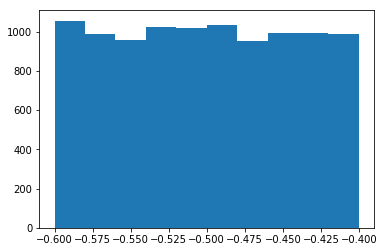

In [20]:
initial_positions = []
for _ in range(10000):
    state = env.reset()
    initial_positions.append(state[0])

plt.hist(initial_positions)
plt.show()

We can see that start positions are uniformly distributed over segment [-0.6, -0.4]. Also we know that mountains are from both side of initial position. To reach goal car have to clumb high into the mountains. Thus, let's give additional reward according to car's height in the mountains. In current task it is equalent to distance from initial position: the more is distance the more is height. Beside major goal this reward will in some kind encorage exploration of space.

In [21]:
initial_position = np.mean(initial_positions)
initial_position

-0.5006513853181341

In [22]:
def potential(x):
    return abs(x - initial_position)

In [23]:
def calc_reward_potential(state, reward, next_state):
    return reward + potential(next_state[0])

In [24]:
def calc_reward_potential_v2(state, reward, next_state):
    return reward + 1000 * (0.99 * potential(next_state[0]) - potential(state[0]))

#### Reward function visualisation

Reward shaping technique used above aimes at making some states more desirable. Let's draw that.

In [25]:
reward_functions = [calc_reward_kinetic,
                    calc_reward_potential]

In [26]:
def visualize_reward_function(reward_function, N=100, title=""):
    """Visualise policy of model for Mountain car"""
    loc_max, speed_max = env.observation_space.high
    loc_min, speed_min = env.observation_space.low
    locs = np.linspace(loc_min, loc_max, N)
    speeds = np.linspace(speed_min, speed_max, N)
    
    reward_values = np.array([reward_function(None, 0, (loc, speed)) for speed in speeds for loc in locs]).reshape((N, N))

    plt.figure(figsize=(3, 3))
    plt.imshow(reward_values, cmap="gray")
    plt.colorbar()
    plt.title(title)
    
    xticks = list(range(len(locs)))[::int(N/10)]
    xlabels = [round(num, 2) for num in locs[::int(N/10)]]
    yticks = list(range(len(speeds)))[::int(N/10)]
    ylabels = [round(num, 2) for num in speeds[::int(N/10)]]
    plt.xticks(xticks, xlabels, rotation=90)
    plt.yticks(yticks, ylabels)
    plt.xlabel("Location")
    plt.ylabel("Speed")

    plt.show()

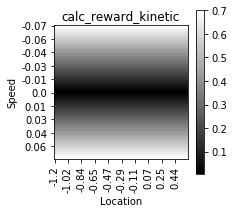

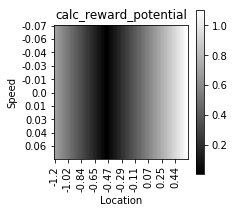

In [27]:
for reward_function in reward_functions:
    visualize_reward_function(reward_function, title=reward_function.__name__)

### Training

For training we will use eps-greedy policy with decreasing eps over time.

In [28]:
def greedy_action(model, state, eps=0):
    """Returns action in accordance with eps-greedy policy"""
    with torch.no_grad():
        if np.random.rand() < eps:
            return np.random.choice(action_space_dim)
        else:
            output = model(torch.tensor(state).float())
            return torch.argmax(output).item()

In [29]:
def validate_model(model, draw=False):
    """Simulate model in environment"""
    state = env.reset()
    total_reward = 0
    done=False
    while not done:
        if draw:
            env.render()
        action = greedy_action(model, state)
        state, reward, done, _ = env.step(action)
        total_reward += reward

    state = env.reset()  
    if draw:
        env.close()
    return total_reward

In [30]:
def train(criterion, reward_function, learning_rate, init_weights_func=init_weights_default, 
          model_hidden_dim=50, auxiliary_task=False,
          time_max=100000, batchsize=128, fixed_model_update=1000, experience_size=5000,
          eps_min=0.1, eps_max=0.5):
    
    env = gym.make("MountainCar-v0")
#     env.seed(2020)
#     np.random.seed(2020)
#     random.seed(2020)
    
    total_rewards = []
    losses = []
    
    model = create_model(model_hidden_dim, auxiliary_task)
    fixed_model = copy.deepcopy(model)
    model.apply(init_weights_func)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    experience = Experience(capacity=experience_size)
    
    state = env.reset()
    
    for time in tqdm(range(time_max)):
        eps = eps_max - (eps_max - eps_min) * time / time_max
        action = greedy_action(model, state, eps)
        next_state, reward, done, _ = env.step(action)
        
        experience.add([
            state,
            action,
            reward_function(state, reward, next_state),
            next_state,
            done
        ])
        
        if time > batchsize:
            loss = fit(model, fixed_model, experience.sample(batchsize), optimizer, criterion) # Train model
            losses.append(loss)
                
        if time % fixed_model_update == 0:
            fixed_model = copy.deepcopy(model)
            total_rewards.append(validate_model(fixed_model))
            
        if done: # Restart simulation
            state = env.reset()
        else:
            state = next_state
    return model, total_rewards, losses

### Experiments

In [31]:
def plot_loss(losses, title, fixed_model_update=1000):
    """Plots loss of predicting q value and loss of predicting reward if available"""
    if isinstance(losses[0], Iterable):
        losses_to_plot = list(zip(*losses))
    else:
        losses_to_plot = [losses]
        
    plt.figure(figsize=(20, 5))
    plt.title(title)
    labels = ["Loss Q values predicting", "Loss Reward predicting"]
    for i, loss in enumerate(losses_to_plot):
        plt.plot(range(len(loss)), loss, label=labels[i])
        
    for x in range(0, len(losses_to_plot[0]), fixed_model_update):
        plt.axvline(x=x, color="red")
    plt.axvline(x=x, color="red", label="Fixed model update") # Smart but lazy way to have only one label for all vertical lines
    plt.legend()
    plt.grid()
    plt.show()

In [32]:
def visualize_policy(model, N=100, title=None):
    """Visualise policy of model for Mountain car"""
    loc_max, speed_max = env.observation_space.high
    loc_min, speed_min = env.observation_space.low
    locs = np.linspace(loc_min, loc_max, N)
    speeds = np.linspace(speed_min, speed_max, N)
    locs, speeds = np.meshgrid(locs, speeds)
    locs, speeds = locs.flatten(), speeds.flatten()
    
    policy_map = [greedy_action(model, (loc, speed)) for (loc, speed) in zip(locs, speeds)]
    
    colors = {0:'lime',1:'blue',2:'red'}
    policy_colors = [colors[policy] for policy in policy_map]
    labels = ['Left','Nothing','Right']

    plt.figure(figsize=(7, 7))
    plt.scatter(locs, speeds, c=policy_colors)
    if title:
        plt.title(title + " model's policy")
    else:
        plt.title("Model's policy")
    plt.xlabel("Location")
    plt.ylabel("Speed")
    
    recs = []
    for i in range(len(labels)):
         recs.append(mpatches.Rectangle((0,0), 1, 1, fc=list(colors.values())[i]))
    plt.legend(recs, labels, loc=4, ncol=3)

    plt.show()

#### Reward function

Now let's compare proposed reward functions (5 in total).

In [33]:
time_max = 30000
criterion = nn.functional.mse_loss
lr = 0.001

reward_functions = [calc_base_reward,
                    calc_reward_kinetic,
                    calc_reward_kinetic_v2,
                    calc_reward_potential,
                    calc_reward_potential_v2]
init_weights_function = init_weights_default

configs_reward_functions = []
results_reward_functions = []
models_reward_functions = []
losses_reward_functions = []

for reward_function in reward_functions:
    config = reward_function.__name__
    model, total_reward, losses = train(criterion,
                                        reward_function,
                                        lr,
                                        init_weights_function,
                                        time_max=time_max,
                                        batchsize=128,
                                        eps_max=0.9, 
                                        experience_size=5000)

    print(f"Training configuration: {config}, mean total reward: {np.mean(total_reward)}")
    configs_reward_functions.append(config)
    results_reward_functions.append(total_reward)
    models_reward_functions.append(model)
    losses_reward_functions.append(losses)


Training configuration: calc_base_reward, mean total reward: -200.0



Training configuration: calc_reward_kinetic, mean total reward: -153.56666666666666



Training configuration: calc_reward_kinetic_v2, mean total reward: -120.23333333333333



Training configuration: calc_reward_potential, mean total reward: -200.0



Training configuration: calc_reward_potential_v2, mean total reward: -200.0


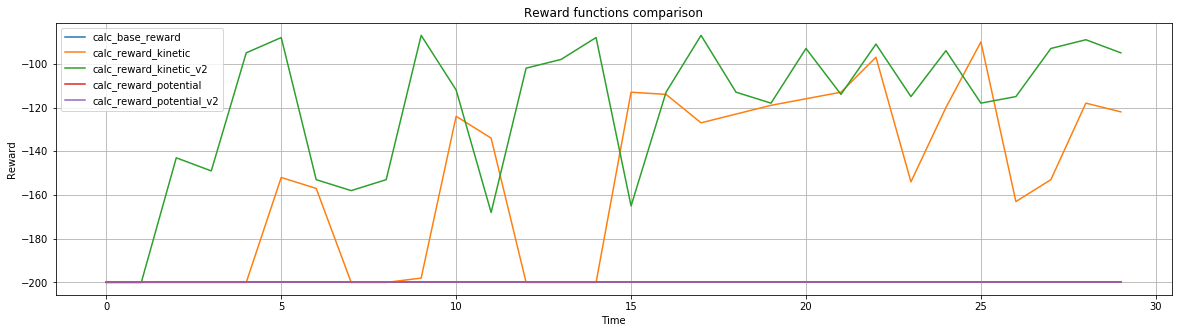

In [38]:
plt.figure(figsize=(20, 5))
plt.title("Reward functions comparison")
for i in range(len(results_reward_functions)):
    plt.plot(range(len(results_reward_functions[i])), results_reward_functions[i], label=configs_reward_functions[i])
plt.legend()
plt.xlabel("Time")
plt.ylabel("Reward")
plt.grid()
plt.show()

Comparing calc_reward_kinetic and calc_reward_kinetic_v2 we see that latter shows more stable results. This proves that using technique mentioned in paper ([Policy invarience under reward transformation. Theory and application of reward shaping](https://people.eecs.berkeley.edu/~pabbeel/cs287-fa09/readings/NgHaradaRussell-shaping-ICML1999.pdf)) works in our case too. 

#### Model's arhitecture

In [39]:
time_max = 30000
criterion = nn.functional.mse_loss
lr = 0.01
reward_function = calc_reward_kinetic_v2
init_weights_function = init_weights_default

model_hidden_dims = [10, 50, 200]
configs_hidden_dim = []
results_hidden_dim = []


for hidden_dim in model_hidden_dims:
    config = str(hidden_dim) + " hidden neurons"
    model, total_reward, _ = train(criterion,
                                   reward_function,
                                   lr,
                                   init_weights_function,
                                   model_hidden_dim=hidden_dim,
                                   time_max=time_max,
                                   batchsize=128)

    print(f"Training configuration: {config}, mean total reward: {np.mean(total_reward)}")
    configs_hidden_dim.append(config)
    results_hidden_dim.append(total_reward)


Training configuration: 10 hidden neurons, mean total reward: -125.73333333333333



Training configuration: 50 hidden neurons, mean total reward: -125.3



Training configuration: 200 hidden neurons, mean total reward: -119.83333333333333


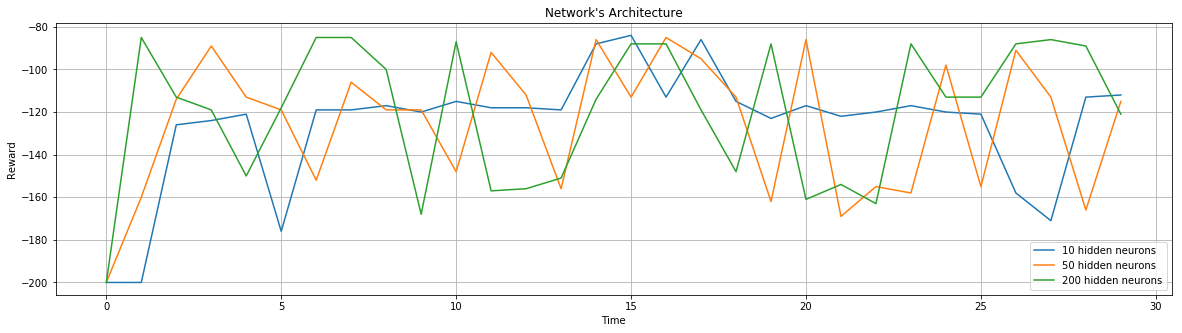

In [40]:
plt.figure(figsize=(20, 5))
plt.title("Network's Architecture")
for i in range(len(results_hidden_dim)):
    plt.plot(range(len(results_hidden_dim[i])), results_hidden_dim[i], label=configs_hidden_dim[i])
plt.legend()
plt.xlabel("Time")
plt.ylabel("Reward")
plt.grid()
plt.show()

What is here interesting is that even with only 10 neurons model can learn how to reach the goal

#### Auxiliary loss

In [42]:
time_max = 50000
criterion = nn.functional.mse_loss
lr = 0.001
reward_function = calc_reward_kinetic_v2
init_weights_function = init_weights_default
hidden_dim = 100

configs_auxiliary_task = []
results_auxiliary_task = []
models_auxiliary_task = []
losses_auxiliary_task = []

for auxiliary_task in [True, False]:
    config = "Model {} auxiliary task".format("with" if auxiliary_task else "without")
    model, total_reward, losses = train(criterion,
                                        reward_function,
                                        lr,
                                        init_weights_function,
                                        model_hidden_dim=hidden_dim,
                                        auxiliary_task=auxiliary_task,
                                        time_max=time_max,
                                        batchsize=128)

    print(f"Training configuration: {config}, mean total reward: {np.mean(total_reward)}")
    configs_auxiliary_task.append(config)
    results_auxiliary_task.append(total_reward)
    models_auxiliary_task.append(model)
    losses_auxiliary_task.append(losses)

Training configuration: Model with auxiliary task, mean total reward: -128.96


Training configuration: Model without auxiliary task, mean total reward: -127.28


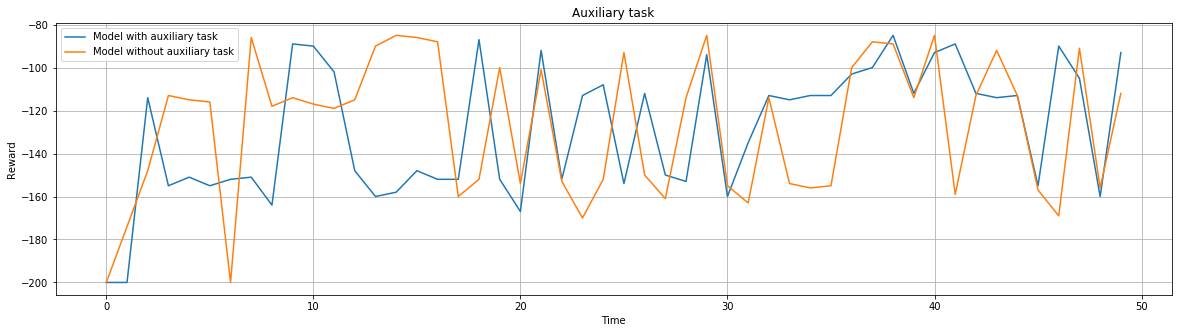

In [43]:
plt.figure(figsize=(20, 5))
plt.title("Auxiliary task")
for i in range(len(results_auxiliary_task)):
    plt.plot(range(len(results_auxiliary_task[i])), results_auxiliary_task[i], label=configs_auxiliary_task[i])
plt.legend()
plt.xlabel("Time")
plt.ylabel("Reward")
plt.grid()
plt.show()

#### Conclusion

We can conclude that:
* Default Pytorch and Xavier weights initialisation show the same perfomance
* MSE and L1 loss functions show the same perfomance
* Even 10 neurons is enough to model policy
* Shaping reward with Kinetic approarch helps model to reach goal
* Model with Auxiliary task in current implementation is not showing much better results than original model 

In [ ]:
# # Let's to a little hack and increase number of steps in environment
# episode_steps_max = 1000 
# env._max_episode_steps = episode_steps_max

In [48]:
# Train best model
best_model, _, losses = train(nn.functional.mse_loss,
                              calc_reward_kinetic_v2,
                              0.01,
                              init_weights_default,
                              time_max=50000)

Reward: -93.0


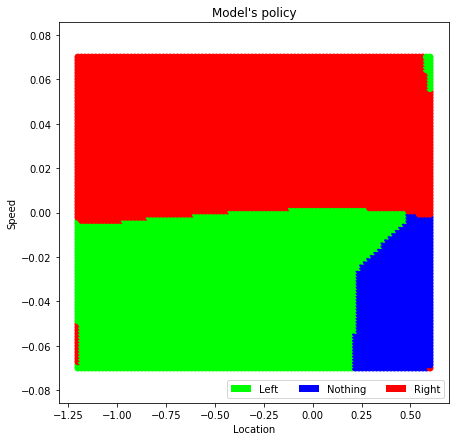

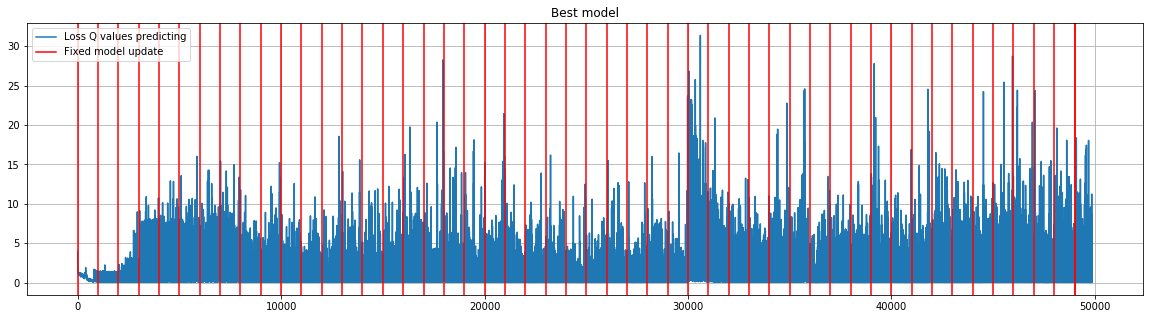

In [50]:
total_reward = validate_model(best_model, draw=True)
print(f"Reward: {total_reward}")
visualize_policy(best_model)
plot_loss(losses, "Best model")

As we can see policies decision boundaries are quite simple, this explains why even 10 is enough or model.

### What's next

Try more recent techniques
* [Hindsight Experience Replay](https://arxiv.org/pdf/1707.01495.pdf)
* [PRIORITIZED EXPERIENCE REPLAY](https://arxiv.org/pdf/1511.05952.pdf)